In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from pathlib import Path
import os
import sys
from IPython.display import display

In [3]:
def on_kaggle_env() -> bool:
    try:
        import gresearch_crypto
        return True
    except ModuleNotFoundError:
        return False

In [4]:
ON_KAGGLE = on_kaggle_env()

In [5]:
if not ON_KAGGLE and os.path.abspath('.').endswith('notebook'):
    os.chdir('../')

In [6]:
#IMPORT_SCRIPT!
if not ON_KAGGLE and '.' not in sys.path:
    sys.path.append('.')
from src.cfg import *
from src.metrics import *
from src.data import ingest_raw_data
from src.cv import TimeSeriesSplit, get_date_range
from src.modeling import Evaluator
# from src.metrics import compute_metrics, compute_correlation
# from src.pipeline.feature_gen import compute_instant_features
# from src.data import infer_dtypes
# from src.pipeline import EXPECTED_RAW_COLS
# from src.pipeline.transforms import FilterFeatures
# from src.modeling import Evaluator
# from src.util import setup_dir

In [7]:
SAMPLE_LEVEL = 0

In [8]:
ENV_CONFIG = setup_env(ON_KAGGLE, sample_level=SAMPLE_LEVEL)

In [9]:
# FILES
DATA_DIR = Path(ENV_CONFIG['dirs']['data_dir'])
RAW_TRAIN_PATH = Path(ENV_CONFIG['dirs']['raw_train_path'])
ASSET_DETAILS_PATH = DATA_DIR / 'asset_details.csv'

In [10]:
%%time 
raw_data = pd.read_csv(RAW_TRAIN_PATH)

CPU times: user 45.2 s, sys: 5.38 s, total: 50.6 s
Wall time: 54.8 s


## create train set

In [11]:
MAIN_INDEX = ['timestamp', 'Asset_ID']

In [12]:
raw_data.head()

,timestamp,Asset_ID,Count,Open,High,Low,Close,Volume,VWAP,Target
0,1514764860,2,40.0,2376.5800,2399.5000,2357.1400,2374.5900,19.233005,2373.116392,-0.004218
1,1514764860,0,5.0,8.5300,8.5300,8.5300,8.5300,78.380000,8.530000,-0.014399
2,1514764860,1,229.0,13835.1940,14013.8000,13666.1100,13850.1760,31.550062,13827.062093,-0.014643
3,1514764860,5,32.0,7.6596,7.6596,7.6567,7.6576,6626.713370,7.657713,-0.013922
4,1514764860,7,5.0,25.9200,25.9200,25.8740,25.8770,121.087310,25.891363,-0.008264


In [13]:
raw_data = ingest_raw_data(raw_data, ASSET_DETAILS_PATH)

In [14]:
raw_data.tail()

,timestamp,Asset_ID,Count,Open,High,Low,Close,Volume,VWAP,Target,time,Asset_Name
23486463,1632181200,13,986.0,0.090885,0.091054,0.090710,0.090941,5.734456e+06,0.090831,0.000199,2021-09-20 23:40:00,TRON
23486464,1632181260,13,715.0,0.091010,0.091277,0.090980,0.091203,1.989048e+06,0.091125,-0.003477,2021-09-20 23:41:00,TRON
23486465,1632181320,13,527.0,0.091171,0.091295,0.091092,0.091180,2.386078e+06,0.091185,-0.002437,2021-09-20 23:42:00,TRON
23486466,1632181380,13,463.0,0.091206,0.091290,0.091028,0.091081,1.568854e+06,0.091131,0.004843,2021-09-20 23:43:00,TRON
23486467,1632181440,13,512.0,0.090989,0.091133,0.090831,0.090885,1.900695e+06,0.090943,0.004163,2021-09-20 23:44:00,TRON


In [15]:
from src.pipeline.feature_gen import compute_minute_features

In [16]:
data = compute_minute_features(raw_data, inference=False)

In [17]:
data.columns

Index(['timestamp', 'Asset_ID', 'Count', 'High', 'Low', 'Close', 'Volume',
       'VWAP', 'Target', 'time', 'Asset_Name', 'upper_shadow', 'lower_shadow',
       'high_low_return', 'open_close_return', 'dolar_amount',
       'vol_per_trades', 'market_close_price', 'market_volume', 'market_count',
       'bitcoin__close', 'bitcoin__volume', 'bitcoin__count'],
      dtype='object')

In [59]:
FEATURES = [
'Count',
'High',
'Low',
'Close',
'Volume',
'VWAP',
'high_low_return',
'open_close_return',
'upper_shadow',
'lower_shadow',
'dolar_amount',
'vol_per_trades',
    'market_close_price', 'market_volume', 'market_count',
       'bitcoin__close', 'bitcoin__volume', 'bitcoin__count'
]

FEATURES = list(set(FEATURES) - set(['Count', 'Volume', 'bitcoin__count', 'bitcoin__volume', 'market_count',
       'market_volume', 'vol_per_trades']))

In [60]:
from sklearn.linear_model import LogisticRegression, LinearRegression, Lasso, Ridge
from sklearn.preprocessing import MinMaxScaler, FunctionTransformer
from sklearn.pipeline import Pipeline
from lightgbm import LGBMRegressor
from src.pipeline.transforms import FilterFeatures

def build_model(params={'alpha': 0.001}):
    model = Pipeline([('filter', FilterFeatures(FEATURES)),
                      ('norm', MinMaxScaler()),
                      ('model', Ridge(params['alpha'], random_state=1))])
    return model

In [61]:
def train_model(config, train_data, valid_data, pipeline=None):
    model  = build_model(config['model'])

    if config['training']['time_decay_alpha'] is not None:
        time_decay_alpha = config['training']['time_decay_alpha']
        print(f'using exponential_time_decay with alpha {time_decay_alpha}')
        timesteps = ((train_data['timestamp'].max() - train_data['timestamp'])//60//60//24)
        weight = time_decay_alpha ** timesteps
    else:
        weight = None

    model.fit(train_data, train_data['Target'], model__sample_weight=weight)
    return model


def get_mask_for_asset(data: pd.DataFrame, asset_id: int):
    return (data['Asset_ID'] == asset_id)


def get_data_for_asset(data: pd.DataFrame, asset_id: int):
    mask = get_mask_for_asset(data, asset_id)
    return data.loc[mask, :].reset_index(drop=True)

In [62]:
def _create_fi_pd(features, importances):
    return (pd.DataFrame({'feature': features, 'importance': importances})
            .sort_values(by=['importance']).reset_index(drop=True))

def compute_fi(config, model, valid_data):
    return _create_fi_pd(model['filter'].features, model['model'].coef_)

In [63]:
CV_PARAMS = {'gap_unit': 'min', 'dt_col': 'time'}


CV = TimeSeriesSplit(ENV_CONFIG['cv_period'], **CV_PARAMS)
asset_ids = raw_data['Asset_ID'].unique()

def run(config, data: pd.DataFrame):
    evaluator = Evaluator(cv=CV, fi_fn=compute_fi)
    
#     data = compute_instant_features(data)
    data.fillna(0, inplace=True)
    RESULTS = {}
    for asset_id in asset_ids:
        asset_data = get_data_for_asset(data, asset_id)
        asset_result = evaluator.run(train_model, config, asset_data)
        RESULTS[asset_id] = asset_result 
    return RESULTS

In [64]:
MODEL_CONFIG = {'alpha': 0.001}
TRAIN_CONFIG = {'time_decay_alpha': None}
CONFIG = {'model': MODEL_CONFIG, 'training': TRAIN_CONFIG}

In [65]:
import itertools

In [ ]:
RESULTS = run(CONFIG, data)

fold=0
elapsed time: 0.0049
fold=1
elapsed time: 0.0068
fold=2
elapsed time: 0.0072
fold=3
elapsed time: 0.0086
fold=0
elapsed time: 0.0058
fold=1
elapsed time: 0.0060
fold=2
elapsed time: 0.0077
fold=3
elapsed time: 0.0074
fold=0
elapsed time: 0.0057
fold=1
elapsed time: 0.0095
fold=2
elapsed time: 0.0115
fold=3
elapsed time: 0.0084
fold=0
elapsed time: 0.0045
fold=1
elapsed time: 0.0058
fold=2
elapsed time: 0.0067
fold=3
elapsed time: 0.0079
fold=0
elapsed time: 0.0021
fold=1
elapsed time: 0.0025
fold=2
elapsed time: 0.0038
fold=3
elapsed time: 0.0028
fold=0
elapsed time: 0.0045
fold=1
elapsed time: 0.0071
fold=2
elapsed time: 0.0078
fold=3
elapsed time: 0.0088
fold=0
elapsed time: 0.0051
fold=1
elapsed time: 0.0080
fold=2


In [ ]:
inference_df = pd.concat(itertools.chain(*[asset_result['prediction'] for _, asset_result in RESULTS.items()]))
scores = inference_df.groupby('fold').apply(compute_metrics).reset_index()
scores['eval_period'] = ENV_CONFIG['cv_period']

In [ ]:
scores

In [27]:
scores

,fold,corr,crypto_consistency,sharpe,corr_period_mean,corr_period_std,consistency,min_period_corr,corr_min,corr_max,corr_std,eval_period
0,0,0.035439,13.0,1.211896,0.017427,0.014380,1.000000,0.002919,-0.012542,0.126943,0.039410,"[2020-01-01, 2020-04-01]"
1,1,0.002109,11.0,0.052133,0.000870,0.016687,0.611111,-0.031089,-0.035501,0.063000,0.022338,"[2020-09-01, 2021-01-01]"
2,2,0.006652,12.0,0.772704,0.012891,0.016683,0.846154,-0.004553,-0.024462,0.047399,0.015990,"[2021-01-01, 2021-04-01]"
3,3,0.007809,9.0,0.354549,0.006801,0.019182,0.769231,-0.026057,-0.007254,0.042140,0.016789,"[2021-04-01, 2021-07-01]"


In [28]:
print('|    |   fold |       corr |   crypto_consistency |      sharpe |   corr_period_mean |\n|---:|-------:|-----------:|---------------------:|------------:|-------------------:|\n|  0 |      0 | 0.0340875  |                   12 |  0.891724   |        0.0140149   |\n|  1 |      1 | 0.00107583 |                   11 | -0.00378112 |       -6.72739e-05 |\n|  2 |      2 | 0.00639626 |                   10 |  0.730508   |        0.0114782   |\n|  3 |      3 | 0.00803942 |                   10 |  0.333772   |        0.00654437  |')

|    |   fold |       corr |   crypto_consistency |      sharpe |   corr_period_mean |
|---:|-------:|-----------:|---------------------:|------------:|-------------------:|
|  0 |      0 | 0.0340875  |                   12 |  0.891724   |        0.0140149   |
|  1 |      1 | 0.00107583 |                   11 | -0.00378112 |       -6.72739e-05 |
|  2 |      2 | 0.00639626 |                   10 |  0.730508   |        0.0114782   |
|  3 |      3 | 0.00803942 |                   10 |  0.333772   |        0.00654437  |


fold                   1.500000
corr                   0.012400
crypto_consistency    10.750000
sharpe                 0.488056
corr_period_mean       0.007993
corr_period_std        0.017207
consistency            0.768162
min_period_corr       -0.018003
corr_min              -0.027406
corr_max               0.064634
corr_std               0.023568
dtype: float64

In [29]:
corrs_fold = inference_df.groupby('fold').apply(lambda d: compute_correlation(d, group_col='Asset_Name').set_index("Asset_Name")).unstack().T

corrs_fold['cum_corr'] = corrs_fold.mean(axis=1)

In [30]:
corrs_fold = corrs_fold.sort_values(by='cum_corr')

In [31]:
corrs_fold

fold                          0         1         2         3  cum_corr
     Asset_Name                                                        
corr Ethereum Classic -0.012542  0.009021  0.012914  0.014937  0.006082
     Bitcoin           0.030857 -0.005682  0.004573 -0.003841  0.006477
     Binance Coin      0.006568 -0.012384  0.005012  0.028896  0.007023
     Bitcoin Cash      0.028263  0.014111  0.001012 -0.004023  0.009841
     IOTA              0.030118  0.005939  0.014455 -0.006680  0.010958
     Monero            0.015787  0.007773  0.006094  0.018643  0.012074
     EOS.IO            0.035139  0.034431 -0.024462  0.008315  0.013356
     Cardano           0.016725  0.005218  0.005367  0.033679  0.015247
     Litecoin          0.057046  0.006494 -0.006263  0.007167  0.016111
     TRON              0.007842  0.009970  0.023016  0.025532  0.016590
     Stellar           0.038080  0.063000  0.007686 -0.000488  0.027070
     Ethereum          0.077058  0.021047  0.047399 -0.007254  0.034562
     Maker             0.126943 -0.035501  0.004791  0.042140  0.034593
     Dogecoin          0.107702  0.018213  0.019790  0.031335  0.044260

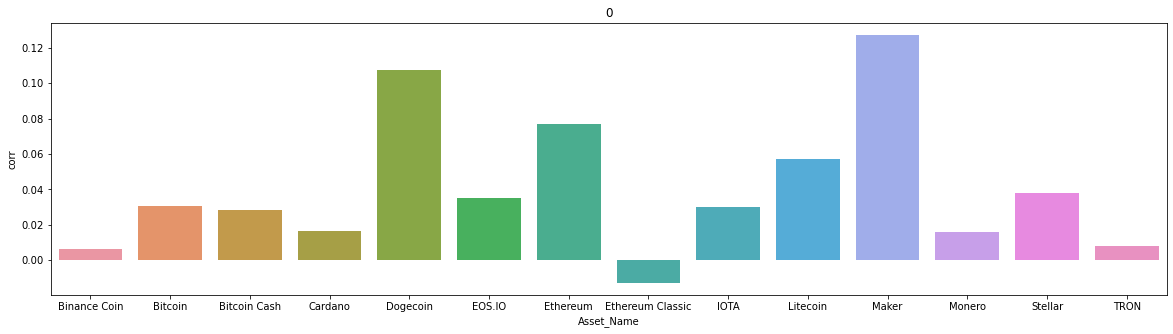

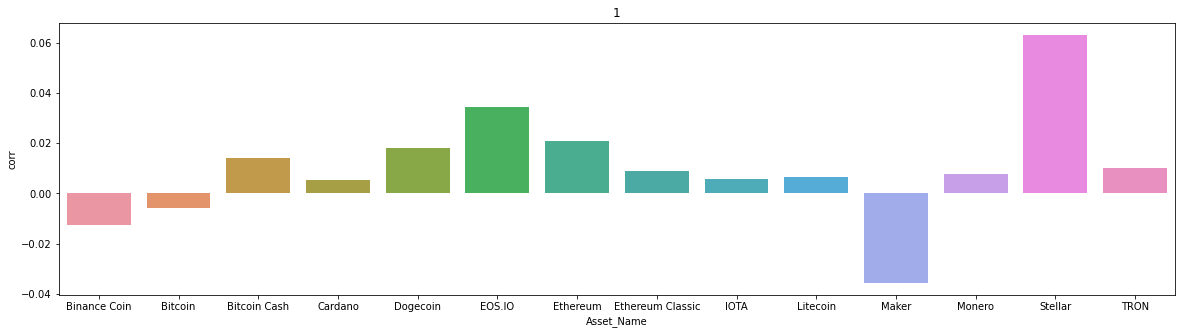

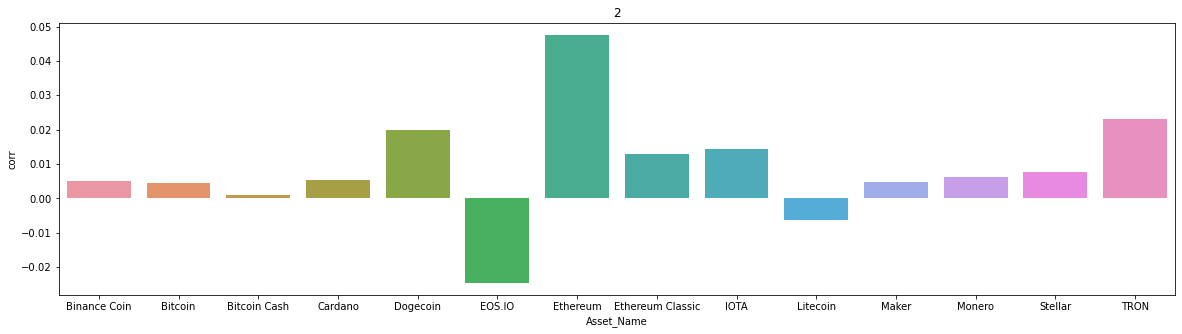

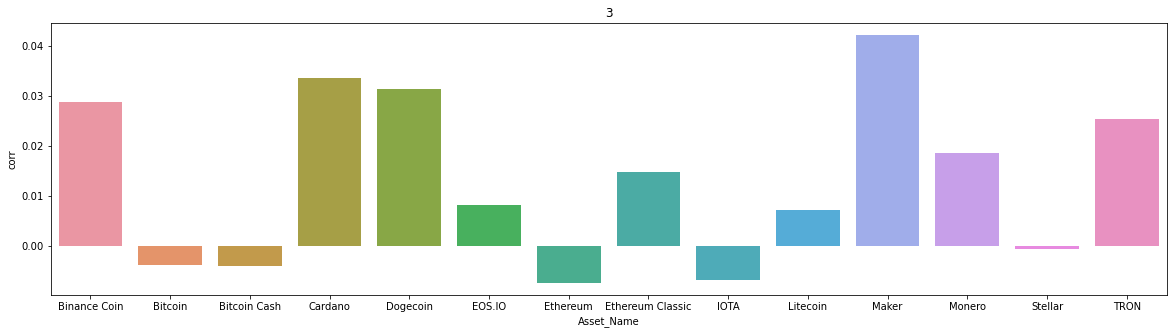

In [32]:
for fold, fold_data in inference_df.groupby('fold'):
    corrs = compute_correlation(fold_data, group_col='Asset_Name')
    plt.figure(figsize=(20, 5))
    sns.barplot(x='Asset_Name', y='corr', data=corrs)
    plt.title(fold)

In [46]:
fi = pd.concat(itertools.chain.from_iterable([asset_result['fi'] for _, asset_result in RESULTS.items()]))

In [50]:
fi_stats = fi.groupby('feature')['importance'].mean()

In [52]:
fi_stats.sort_values()

feature
High                 -0.125843
VWAP                 -0.051460
upper_shadow         -0.027647
lower_shadow         -0.024192
dolar_amount         -0.001422
bitcoin__count       -0.000584
bitcoin__volume      -0.000578
vol_per_trades        0.000221
market_volume         0.000561
Volume                0.000561
Count                 0.000795
market_count          0.000795
bitcoin__close        0.001070
Low                   0.008079
open_close_return     0.019123
Close                 0.025750
market_close_price    0.025750
high_low_return       0.064882
Name: importance, dtype: float64

In [58]:
fi_stats[fi_stats.abs() < 0.001].index

Index(['Count', 'Volume', 'bitcoin__count', 'bitcoin__volume', 'market_count',
       'market_volume', 'vol_per_trades'],
      dtype='object', name='feature')

<AxesSubplot:xlabel='importance', ylabel='feature'>

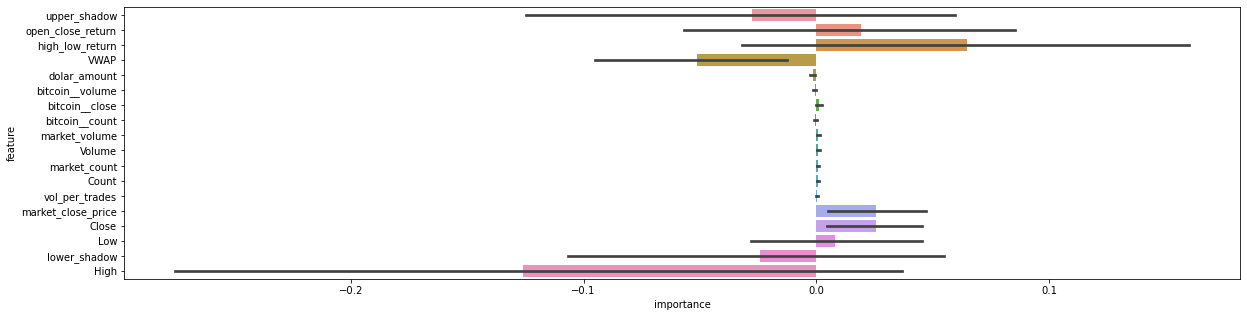

In [48]:
plt.figure(figsize=(20, 5))
sns.barplot(x='importance', y='feature', data=fi)